# CIV1498 - Introduction to Data Science
## Project - Toronto Bike Share
## PART I: Data Wrangling and Cleaning
### By: Gneiss Data (Greig Knox and Yoko Yanagimura)

## 0. Setup Notebook

In [1]:
# Import 3rd party libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import pytz
import fuzzywuzzy
from fuzzywuzzy import process
import chardet
import string
from datetime import datetime

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

# Centre all the charts displayed in this notebook
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
display: table-cell;
text-align: center;
vertical-align: middle;
}
</style>
""")

# 1. Weather Data - Importing Data

In this section, a dataframe is created containing the weather data from January 2017 to December 2020 collected at the Toronto City Center weather station (Weather Station ID 6158359). The raw weather data was provided in csv format. 

In [2]:
#Get list of Weather Data File Names contained in the repository
weather_filenames = [filename for filename in os.listdir() if '6158359' in filename]
print(weather_filenames[0:5])

# Check the format of the weather data
df_weather_data = pd.read_csv(weather_filenames[0])
df_weather_data.head(10)

['en_climate_hourly_ON_6158359_01-2017_P1H.csv', 'en_climate_hourly_ON_6158359_01-2018_P1H.csv', 'en_climate_hourly_ON_6158359_01-2019_P1H.csv', 'en_climate_hourly_ON_6158359_01-2020_P1H.csv', 'en_climate_hourly_ON_6158359_02-2017_P1H.csv']


,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Time,Temp (°C),...,Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather
0,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 00:00,2017,1,1,00:00,1.5,...,NaN,16.1,NaN,99.81,NaN,NaN,NaN,NaN,NaN,NaN
1,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 01:00,2017,1,1,01:00,1.5,...,NaN,16.1,NaN,100.01,NaN,NaN,NaN,NaN,NaN,NaN
2,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 02:00,2017,1,1,02:00,1.0,...,NaN,16.1,NaN,100.14,NaN,NaN,NaN,NaN,NaN,NaN
3,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 03:00,2017,1,1,03:00,1.2,...,NaN,16.1,NaN,100.32,NaN,NaN,NaN,NaN,NaN,NaN
4,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 04:00,2017,1,1,04:00,1.3,...,NaN,16.1,NaN,100.48,NaN,NaN,NaN,NaN,NaN,NaN
5,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 05:00,2017,1,1,05:00,1.0,...,NaN,16.1,NaN,100.55,NaN,NaN,NaN,NaN,NaN,NaN
6,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 06:00,2017,1,1,06:00,0.7,...,NaN,16.1,NaN,100.65,NaN,NaN,NaN,NaN,NaN,NaN
7,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 07:00,2017,1,1,07:00,0.0,...,NaN,16.1,NaN,100.79,NaN,NaN,NaN,-6.0,NaN,NaN
8,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 08:00,2017,1,1,08:00,-0.3,...,NaN,16.1,NaN,100.93,NaN,NaN,NaN,-6.0,NaN,NaN
9,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 09:00,2017,1,1,09:00,-0.1,...,NaN,16.1,NaN,101.06,NaN,NaN,NaN,-6.0,NaN,NaN


Now, the weather data is concatenated into a single dataframe

In [3]:
#Concatenate the weather data from 2017 to 2020 into a single dataframe
df_weather_data = pd.DataFrame()

for file in weather_filenames:
    df_weather_data = pd.concat([df_weather_data,pd.read_csv(file)])

# 2. Weather Data - Data Wrangling

Because the weather data included in the repository are collected from a single weather station, the station information including the station name, station/climate ID, latitude and longitude of the station location, is redundant data and can be removed from the dataframe to reduce the number of columns. We show below what this will look like applied to one of the weather dataset extracted from en_climate_hourly_ON_6158359_08-2020_P1H.csv. The number of column in the dataframe is reduced from 28 to 24. 

In [4]:
#clean column headers
def clean_special_charaters(a_string):
    output = ''
    a_string = a_string.lower()
    for character in a_string:
        if character == ' ' or character == '_':
            output+='_'
        elif character.isalnum():
            output+=character      
    return output
    
punctuations = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

#remove all punctuation from column headers
df_weather_data.columns = [ clean_special_charaters(header)  for header in df_weather_data.columns]

df_weather_data.head()

,longitude_x,latitude_y,station_name,climate_id,datetime,year,month,day,time,temp_c,...,wind_spd_flag,visibility_km,visibility_flag,stn_press_kpa,stn_press_flag,hmdx,hmdx_flag,wind_chill,wind_chill_flag,weather
0,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 00:00,2017,1,1,00:00,1.5,...,NaN,16.1,NaN,99.81,NaN,NaN,NaN,NaN,NaN,NaN
1,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 01:00,2017,1,1,01:00,1.5,...,NaN,16.1,NaN,100.01,NaN,NaN,NaN,NaN,NaN,NaN
2,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 02:00,2017,1,1,02:00,1.0,...,NaN,16.1,NaN,100.14,NaN,NaN,NaN,NaN,NaN,NaN
3,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 03:00,2017,1,1,03:00,1.2,...,NaN,16.1,NaN,100.32,NaN,NaN,NaN,NaN,NaN,NaN
4,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 04:00,2017,1,1,04:00,1.3,...,NaN,16.1,NaN,100.48,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#Save the weather station information in a dictionary
dic_weather_station_info = {'lon':df_weather_data['longitude_x'].iloc[0],'lat': df_weather_data['latitude_y'].iloc[0], 'name':df_weather_data['station_name'].iloc[0],'id':df_weather_data['climate_id'].iloc[0]}

#Drop the station information, drop 4 columns from the dataframe
df_weather_data = df_weather_data.drop(columns = ['longitude_x','latitude_y','station_name','climate_id'])
print(dic_weather_station_info)


{'lon': -79.4, 'lat': 43.63, 'name': 'TORONTO CITY CENTRE', 'id': 6158359}


Furthermore, it has been identified that the columns with the term "flag" do not contain information required for our analysis. These columns are also removed from the dataframe, further reducing the column number from 24 to 15. 

In [6]:
#Drop list of features that have a nan description
lst_na_description = ['temp_flag','dew_point_temp_flag','rel_hum_flag','wind_dir_flag', 'wind_spd_flag', 'visibility_flag', 'stn_press_flag', 'hmdx_flag','wind_chill_flag']
df_weather_data = df_weather_data.drop(columns = lst_na_description)
print(df_weather_data.shape)
df_weather_data.head()


(35064, 15)


,datetime,year,month,day,time,temp_c,dew_point_temp_c,rel_hum_,wind_dir_10s_deg,wind_spd_kmh,visibility_km,stn_press_kpa,hmdx,wind_chill,weather
0,2017-01-01 00:00,2017,1,1,00:00,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,NaN
1,2017-01-01 01:00,2017,1,1,01:00,1.5,-3.9,67.0,27.0,35.0,16.1,100.01,NaN,NaN,NaN
2,2017-01-01 02:00,2017,1,1,02:00,1.0,-4.3,68.0,26.0,32.0,16.1,100.14,NaN,NaN,NaN
3,2017-01-01 03:00,2017,1,1,03:00,1.2,-4.3,67.0,26.0,37.0,16.1,100.32,NaN,NaN,NaN
4,2017-01-01 04:00,2017,1,1,04:00,1.3,-4.4,66.0,26.0,28.0,16.1,100.48,NaN,NaN,NaN


At this point, the weather data has been concatenated into a single dataframe, and the station information and "flag" columns have been dropped from the concatenated dataframe. Below we provide a summary of the percentable of data containing a null value in the dataframe. 

In [7]:
#Percentage of Data Containing Null Record
df_weather_data_missing = pd.DataFrame(df_weather_data.isnull().sum())
df_weather_data_missing = df_weather_data_missing.rename(columns={0:"count"})
df_weather_data_missing['percent_nulldata']=round(df_weather_data_missing['count']/df_weather_data.shape[0] * 100,1)

print("")
print('The number of data records in the data frame is:' ,df_weather_data.shape[0])

df_weather_data_missing


The number of data records in the data frame is: 35064


,count,percent_nulldata
datetime,0,0.0
year,0,0.0
month,0,0.0
day,0,0.0
time,0,0.0
temp_c,459,1.3
dew_point_temp_c,508,1.4
rel_hum_,500,1.4
wind_dir_10s_deg,2385,6.8
wind_spd_kmh,384,1.1


In [8]:
#df_weather_data = df_weather_data[df_weather_data['temp_c'].notnull()]

#print("There are {:.0f} weather records with temperature data".format(df_weather_data.shape[0]))
#df_weather_data.head()

It has been determined that more than 80% of the Hmdx and Wind Chill are null values. 

Looking into the provided information on https://climate.weather.gc.ca, however, it was determined that hourly humidex values are only displayed when the air temperature is 20 deg C or greater and the humidex value is at least 1 degree greater than the air temperature. Wind Chill is also only displayed when the hourly temperature is less than or equal to 0 deg C. These columns will therefore be left in our dataframe because we have an understanding of when they would be missing from the records.

In [9]:
#Hmdx is only calculated if air temperture is greater than 20 deg and humidex (H_value) is at least 1 deg or more
e = 6.11 * np.exp(5417.7530 * ( (1/273.15) - (1/(df_weather_data['dew_point_temp_c']+273.15))))
df_weather_data['h_value']=(0.5555)*(e - 10.0)

df_weather_data[df_weather_data['hmdx'].notnull()].head()

,datetime,year,month,day,time,temp_c,dew_point_temp_c,rel_hum_,wind_dir_10s_deg,wind_spd_kmh,visibility_km,stn_press_kpa,hmdx,wind_chill,weather,h_value
427,2017-05-18 19:00,2017,5,18,19:00,25.5,16.7,58.0,28.0,28.0,16.1,99.66,31.0,NaN,NaN,5.087083
428,2017-05-18 20:00,2017,5,18,20:00,24.7,15.8,57.0,30.0,24.0,16.1,99.76,29.0,NaN,NaN,4.485201
429,2017-05-18 21:00,2017,5,18,21:00,22.8,13.8,56.0,29.0,17.0,16.1,99.84,26.0,NaN,NaN,3.255232
430,2017-05-18 22:00,2017,5,18,22:00,21.8,13.1,57.0,27.0,18.0,16.1,99.96,25.0,NaN,NaN,2.857706
687,2017-05-29 15:00,2017,5,29,15:00,23.5,9.8,41.0,25.0,28.0,16.1,99.93,25.0,NaN,NaN,1.191371


In [10]:
#Remove the Humidex_Calc column, not needed for future analysis
df_weather_data=df_weather_data.drop(columns = ['h_value'])

In [11]:
#WindChill is Nan for temperatures greater than 0 deg
df_weather_data[df_weather_data['wind_chill'].isnull()].head()

,datetime,year,month,day,time,temp_c,dew_point_temp_c,rel_hum_,wind_dir_10s_deg,wind_spd_kmh,visibility_km,stn_press_kpa,hmdx,wind_chill,weather
0,2017-01-01 00:00,2017,1,1,00:00,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,NaN
1,2017-01-01 01:00,2017,1,1,01:00,1.5,-3.9,67.0,27.0,35.0,16.1,100.01,NaN,NaN,NaN
2,2017-01-01 02:00,2017,1,1,02:00,1.0,-4.3,68.0,26.0,32.0,16.1,100.14,NaN,NaN,NaN
3,2017-01-01 03:00,2017,1,1,03:00,1.2,-4.3,67.0,26.0,37.0,16.1,100.32,NaN,NaN,NaN
4,2017-01-01 04:00,2017,1,1,04:00,1.3,-4.4,66.0,26.0,28.0,16.1,100.48,NaN,NaN,NaN


It is also noted that 84% of the data in the Weather column are also null. The weather field in this dataset contains observations of the atmospheric phenonemom including the occurence of weather and obstructions to vision. We have determined that there is value in exploring the reason for this. 

In [12]:
#Display unique values in the Weather column
df_weather_data['weather'].unique().tolist()

[nan,
 'Fog',
 'Rain,Fog',
 'Rain',
 'Snow',
 'Moderate Rain',
 'Moderate Rain,Fog',
 'Haze',
 'Rain,Snow',
 'Freezing Rain,Fog',
 'Snow,Blowing Snow',
 'Heavy Snow',
 'Moderate Snow',
 'Haze,Blowing Snow',
 'Heavy Rain,Fog',
 'Thunderstorms,Rain,Fog',
 'Freezing Rain,Snow',
 'Freezing Rain',
 'Thunderstorms,Rain',
 'Thunderstorms,Moderate Rain,Fog',
 'Thunderstorms,Moderate Rain',
 'Thunderstorms',
 'Thunderstorms,Heavy Rain,Fog',
 'Thunderstorms,Heavy Rain',
 'Thunderstorms,Fog']

You can see that only abnormal weather events are listed, but there is no reference to any 'clear day'. This means that when `weather_data['Weather'] == NaN`, the conditions are actually clear. Therefore, we've established that we do not want to remove rows where `weather_data['Weather'] == NaN`. Instead, we have change all the NaN values in the weather field to 'clear_day' to reflect this understanding. 

In [13]:
#Change all Nan values into 'clear_day' in the weather column
df_weather_data['weather'] = df_weather_data['weather'].fillna('clear_day')

#Replace spaces and remove capital letters in the weather column
df_weather_data['weather'] = df_weather_data['weather'].str.replace(" ","_")

#Check that change has been effected
df_weather_data['weather'].unique().tolist()

['clear_day',
 'Fog',
 'Rain,Fog',
 'Rain',
 'Snow',
 'Moderate_Rain',
 'Moderate_Rain,Fog',
 'Haze',
 'Rain,Snow',
 'Freezing_Rain,Fog',
 'Snow,Blowing_Snow',
 'Heavy_Snow',
 'Moderate_Snow',
 'Haze,Blowing_Snow',
 'Heavy_Rain,Fog',
 'Thunderstorms,Rain,Fog',
 'Freezing_Rain,Snow',
 'Freezing_Rain',
 'Thunderstorms,Rain',
 'Thunderstorms,Moderate_Rain,Fog',
 'Thunderstorms,Moderate_Rain',
 'Thunderstorms',
 'Thunderstorms,Heavy_Rain,Fog',
 'Thunderstorms,Heavy_Rain',
 'Thunderstorms,Fog']

In the weather data, there is also 1.1% or 384 records with null values for the wind speed. Originally we thought that the null values represented instances when no wind was detected (0 km/h), but we also found records where wind speed is already equal to 0 km/h. At this point, we are uncertain what this NaN value indicates for wind speed. It could be that the wind speed was too low and undetectable or it could also mean that it exceeded the maximum detectable wind speed. If the latter were true, it would be erroneous to assume that the wind speed is 0 km/h. For this reason, we decided to leave the null values in there and evaluate the missingness on a case by case basis, if necessary. 

In [14]:
#Examine the unique values assigned to wind speed
print(df_weather_data['wind_spd_kmh'].unique())

#Examine the dataframe where wind speed is null
df_weather_data[df_weather_data['wind_spd_kmh'].isnull()].head()

[39. 35. 32. 37. 28. 30. 26. 22. 18. 17. 15. 21. 11.  8.  0.  4. 13. 24.
  9.  5. 41. 52. 46. 50. 55. 45. 48. 34. 43. 61. 54. nan 58. 63. 59. 65.
 74. 68. 72. 67. 76.]


,datetime,year,month,day,time,temp_c,dew_point_temp_c,rel_hum_,wind_dir_10s_deg,wind_spd_kmh,visibility_km,stn_press_kpa,hmdx,wind_chill,weather
320,2020-01-14 08:00,2020,1,14,08:00,1.6,-0.2,88.0,NaN,NaN,16.1,101.36,NaN,NaN,clear_day
323,2020-01-14 11:00,2020,1,14,11:00,2.3,0.2,86.0,NaN,NaN,16.1,101.14,NaN,NaN,clear_day
326,2020-01-14 14:00,2020,1,14,14:00,1.3,0.4,94.0,NaN,NaN,9.7,100.67,NaN,NaN,clear_day
334,2020-01-14 22:00,2020,1,14,22:00,NaN,NaN,91.0,NaN,NaN,9.7,NaN,NaN,NaN,Fog
343,2020-01-15 07:00,2020,1,15,07:00,3.1,-1.4,72.0,NaN,NaN,16.1,101.24,NaN,NaN,clear_day


In the weather data, there is also 6.8% or 2385 records with null values for the wind direction. In https://climate.weather.gc.ca, it is provided that a wind direction of 0 is assigned to denote a calm wind. However, looking into the data there is no instance of zero in the data. Also looking at the wind speed associated with the null wind direction values, the maximum speed observed was 21 km/hour, while the wind speed in the data ranges from 0 to 76 km/hr. Thus, it has been assumed that a null value as been assigned to what should have been 0 for wind direction, denoting a calm wind. For records with null value for wind speed, the wind direction was also left as a null value. 

In [15]:
#Examine the dataframe where wind direction is equal to 0
print(df_weather_data[df_weather_data['wind_dir_10s_deg']==0].shape) 
print('There is no records with wind direction = 0')

#Max wind speed value in the weather dataframe
print('Max wind speed in entire dataframe (km/h):', max(df_weather_data['wind_spd_kmh'].unique()))

#Examine the range of wind speed for null wind direction
print('Max wind speed for records with null wind direction:',max(df_weather_data[df_weather_data['wind_dir_10s_deg'].isnull()]['wind_spd_kmh'].unique()))

#Assume that null values in Wind Direction denotes a calm wind represented by 0, except for when wind speed is null
lst_to_replace = (df_weather_data['wind_spd_kmh'].notnull()) & (df_weather_data['wind_dir_10s_deg'].isnull())
for i in range(len(lst_to_replace)):
    if lst_to_replace.iloc[i]: 
        df_weather_data.iloc[i,8] = 0

(0, 15)
There is no records with wind direction = 0
Max wind speed in entire dataframe (km/h): 76.0
Max wind speed for records with null wind direction: 21.0


In [16]:
#Check unique values assigned to records where wind speed is not null
print(df_weather_data[df_weather_data['wind_spd_kmh'].notnull()]['wind_dir_10s_deg'].unique())

[26. 27. 23. 24. 25. 22.  0.  3.  5.  6.  8.  7. 10.  9.  4. 33. 28. 29.
 31. 30. 32. 20. 21. 19. 18. 15. 14. 12. 13. 16. 17. 34. 35. 11.  1. 36.
  2.]


In [17]:
#Check unique values assigned to records where wind speed is null
print(df_weather_data[df_weather_data['wind_spd_kmh'].isnull()]['wind_dir_10s_deg'].unique())

[nan]


Looking at the records with null values for visibility, we can see that all these days tend to all fall on clear days. As such, we have interpreted the null values to represent no visibility issue. To reflect our understanding of this in the dataframe, we have replaced the null values with a positive infinity value. This will be the largest visibility distance in the dataset.  

In [18]:
#Examine the unique values assigned to Visibility
print(df_weather_data['visibility_km'].unique())

#Examine records with Weather associated with null values assigned to Visibility column
print(df_weather_data[df_weather_data['visibility_km'].isnull()]['weather'].unique())

#Examine records with Weather associated with 16.1 km Visibility
print(df_weather_data[df_weather_data['visibility_km']==16.1]['weather'].unique())

[16.1 12.9  9.7 11.3  6.4  3.2  4.8 14.5  8.1  2.4  2.8  1.6  2.   4.
  1.   0.4  3.6  0.8  0.6  1.2  0.   0.2  nan]
['clear_day']
['clear_day' 'Rain' 'Snow' 'Rain,Snow' 'Moderate_Rain' 'Freezing_Rain'
 'Thunderstorms,Rain' 'Thunderstorms,Moderate_Rain' 'Thunderstorms']


In [19]:
#Replace all null values in visibility with infinity 
df_weather_data['visibility_km'] = df_weather_data['visibility_km'].fillna(np.inf)
 
#Check the dataframe
df_weather_data.sort_values('visibility_km', ascending =False).head()

,datetime,year,month,day,time,temp_c,dew_point_temp_c,rel_hum_,wind_dir_10s_deg,wind_spd_kmh,visibility_km,stn_press_kpa,hmdx,wind_chill,weather
743,2020-12-31 23:00,2020,12,31,23:00,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN,NaN,clear_day
475,2020-12-20 19:00,2020,12,20,19:00,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN,NaN,clear_day
477,2020-12-20 21:00,2020,12,20,21:00,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN,NaN,clear_day
478,2020-12-20 22:00,2020,12,20,22:00,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN,NaN,clear_day
479,2020-12-20 23:00,2020,12,20,23:00,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN,NaN,clear_day


Through the process of examining the null values found for each field column and applying the appropriate data wrangling techniques, we were able to reduce the total number of missing records in the weather dataframe. 

At this point, we can make sure we have removed all weather records with null values for all the columns.

In [20]:
original_count=df_weather_data.shape[0]
df_weather_data.dropna(subset = ['temp_c','rel_hum_','wind_dir_10s_deg','wind_spd_kmh','visibility_km','hmdx','wind_chill','weather'], 
                       how='all', inplace=True)
print('Number of records removed from Trip Dataframe: ', original_count - df_weather_data.shape[0])

Number of records removed from Trip Dataframe:  0




We can see that the first 6 columns of `weather_data_missing` have no missing data.

For the humidex and wind chill column, we now understand why they are null values. These parameters were not calculated when certain conditions in the weather data was not met. 

Other columns such as temperature, wind speed, wind direction, dew point temperature and relative humidity, there are a few null records but total number of null values in each field is about 1%. We could not confidently determine why there were null values in this column fields, but because there is so few of them, we will address the missingness on a case-by-case basis depending on which columns we're analyzing. 


In [21]:
#Percentage of Data Containing Null Record
weather_data_missing = pd.DataFrame(df_weather_data.isnull().sum())
weather_data_missing = weather_data_missing.rename(columns={0:"count"})
weather_data_missing['percent_nulldata']=round(weather_data_missing['count']/df_weather_data.shape[0] * 100,1)

print("")
print('The number of data records in the data frame is:' ,df_weather_data.shape[0])

weather_data_missing


The number of data records in the data frame is: 35064


,count,percent_nulldata
datetime,0,0.0
year,0,0.0
month,0,0.0
day,0,0.0
time,0,0.0
temp_c,459,1.3
dew_point_temp_c,508,1.4
rel_hum_,500,1.4
wind_dir_10s_deg,384,1.1
wind_spd_kmh,384,1.1


# 3.  Weather Data - Date/Time 
> Set Date/Time as index and localize to EST time zone

The Date/Time was originally imported as a string object. When they were converted into a datetime object, the data was time zone naive (i.e. no information on the time zone was provided for the data to unambiguously locate itself relative to other date/time objects). In other words, the timestamp was not localized to any specific time zone. 

In [22]:
df_weather_data = df_weather_data.set_index('datetime')
df_weather_data.index = pd.DatetimeIndex(df_weather_data.index)
df_weather_data=df_weather_data.tz_localize(tz='EST')

# View DataFrame
df_weather_data.head()

,year,month,day,time,temp_c,dew_point_temp_c,rel_hum_,wind_dir_10s_deg,wind_spd_kmh,visibility_km,stn_press_kpa,hmdx,wind_chill,weather
datetime,,,,,,,,,,,,,,
2017-01-01 00:00:00-05:00,2017,1,1,00:00,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day
2017-01-01 01:00:00-05:00,2017,1,1,01:00,1.5,-3.9,67.0,27.0,35.0,16.1,100.01,NaN,NaN,clear_day
2017-01-01 02:00:00-05:00,2017,1,1,02:00,1.0,-4.3,68.0,26.0,32.0,16.1,100.14,NaN,NaN,clear_day
2017-01-01 03:00:00-05:00,2017,1,1,03:00,1.2,-4.3,67.0,26.0,37.0,16.1,100.32,NaN,NaN,clear_day
2017-01-01 04:00:00-05:00,2017,1,1,04:00,1.3,-4.4,66.0,26.0,28.0,16.1,100.48,NaN,NaN,clear_day


 # 4. Visualization of the Weather Data

This section verifies the robustness of the weather data through various visualization techniques. 

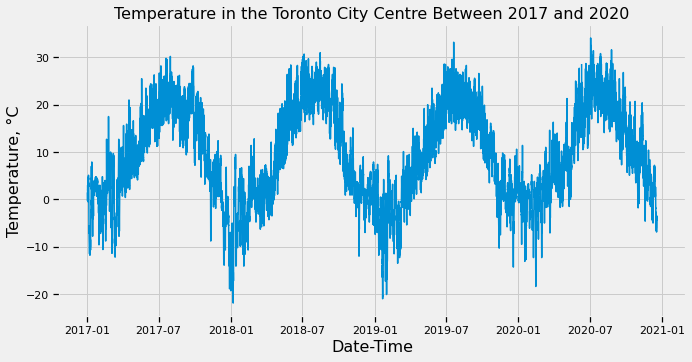

In [23]:
plt.figure(figsize=(10,5))
temp=sns.lineplot(x=df_weather_data.index,y=df_weather_data['temp_c'])
temp.axes.set_title("Temperature in the Toronto City Centre Between 2017 and 2020",
                      fontsize=16)
temp.set_ylabel("Temperature, °C",
                  fontsize=16)
temp.set_xlabel("Date-Time",
                  fontsize=16)
plt.show()


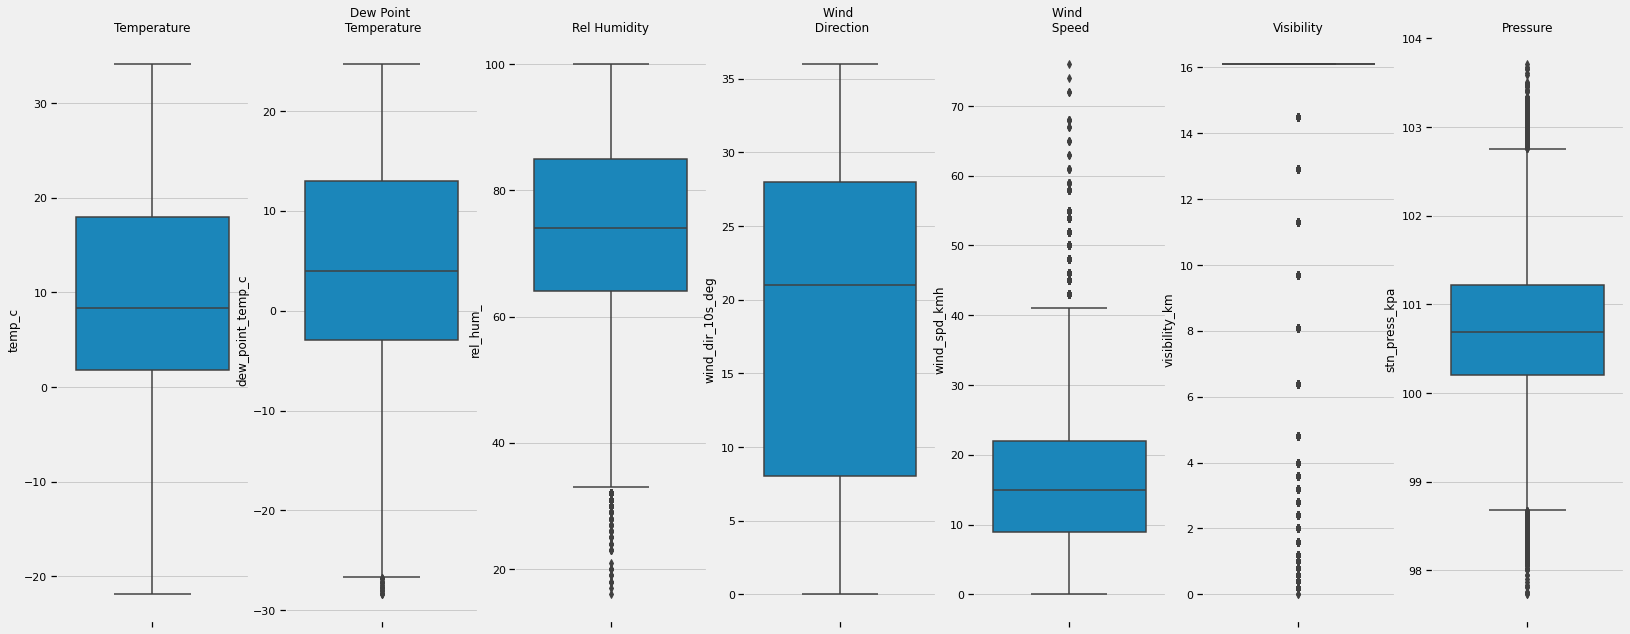

In [24]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1,7,figsize = (25,10))

sns.boxplot(y = 'temp_c', data = df_weather_data, ax = ax1)
ax1.set_title('Temperature')

sns.boxplot(y = 'dew_point_temp_c', data = df_weather_data, ax = ax2)
ax2.set_title('Dew Point \n Temperature')

sns.boxplot(y = 'rel_hum_', data = df_weather_data, ax = ax3)
ax3.set_title('Rel Humidity')

sns.boxplot(y = 'wind_dir_10s_deg', data = df_weather_data, ax = ax4)
ax4.set_title('Wind \n Direction')

sns.boxplot(y = 'wind_spd_kmh', data = df_weather_data, ax = ax5)
ax5.set_title('Wind \n Speed')

sns.boxplot(y = 'visibility_km', data = df_weather_data, ax = ax6)
ax6.set_title('Visibility')

sns.boxplot(y = 'stn_press_kpa', data = df_weather_data, ax = ax7)
ax7.set_title('Pressure')

fig.show()

The reason why the boxplot for the visibility is not showing up is because a significant portion of the data indicate a visibility of 16.1 km. For this reason the 1st, 2nd and 3rd quartile is essentially the same value.

In [25]:
#Estimate quartile values for Visibility column
Q1=np.percentile(df_weather_data['visibility_km'], 25)  # Q1
Q2=np.percentile(df_weather_data['visibility_km'], 50)  # median
Q3=np.percentile(df_weather_data['visibility_km'], 75)  # Q3

print("Q1=",Q1)
print("Q2=",Q2)
print("Q3=",Q3)

Q1= 16.1
Q2= 16.1
Q3= 16.1


Because of the high number of clear weather days in the data set, it is very plausible that there is also high number of records indicate 16.1 km (or higher) of visibility distance. 

In [26]:
print('{:.2f}% of the weather records indicate a visibility 16.1 km or higher. Similarly {:.2f}% of the days are have clear skies'
      .format((df_weather_data['visibility_km'] >= 16.1).sum()/df_weather_data.shape[0]*100
              , (df_weather_data['weather'] == 'clear_day').sum()/df_weather_data.shape[0]*100))

87.21% of the weather records indicate a visibility 16.1 km or higher. Similarly 84.27% of the days are have clear skies


The final process in the data wrangling process is to export the manipulated data as a csv for easy access. 

In [27]:
#Export the weather dataframe in csv format
df_weather_data.to_csv('cleaned_weather_data_set.csv')

# 5. Bike Share Trip Data - Import Data

In this section,  a dataframe is created containing the historical ridership data in Toronto from January 2017 to October 2020. The bike trip data was provided in csv format with one file for every month.

The main challenge with merging these csv files is the change in column field between 2018 and 2019. For example, the bike triip data from 2017 and 2019 contain 9 fields, while the bike trip data from 2019 and 2020 contain 11 fields. 

It as also been identified that the date/time indicated in the 2017/2018 data is in UTC while the 2019/2020 data is in EST. The date/time will be localized to the appropriate time zone during the importation process. 

In [28]:
# Create a list of file names for bike share trips data contained in repository
trips_filenames = [filename for filename in os.listdir() if 'bike_share' in filename]

# Create a dictionary where key:value pairs correspond to the file name and DataFrame respectively
trips_data = {filename: pd.read_csv(filename) for filename in trips_filenames}

# Now let's print out the column names for the first month of each year
print('2017\n{}\n'.format(trips_data['bike_share_2017-1.csv'].columns.tolist()))
print('2018\n{}\n'.format(trips_data['bike_share_2018-1.csv'].columns.tolist()))
print('2019\n{}\n'.format(trips_data['bike_share_2019-1.csv'].columns.tolist()))
print('2020\n{}\n'.format(trips_data['bike_share_2020-1.csv'].columns.tolist()))

2017
['trip_id', 'trip_start_time', 'trip_stop_time', 'trip_duration_seconds', 'from_station_id', 'from_station_name', 'to_station_id', 'to_station_name', 'user_type']

2018
['trip_id', 'trip_duration_seconds', 'from_station_id', 'trip_start_time', 'from_station_name', 'trip_stop_time', 'to_station_id', 'to_station_name', 'user_type']

2019
['Trip Id', 'Subscription Id', 'Trip  Duration', 'Start Station Id', 'Start Time', 'Start Station Name', 'End Station Id', 'End Time', 'End Station Name', 'Bike Id', 'User Type']

2020
['Trip Id', 'Subscription Id', 'Trip  Duration', 'Start Station Id', 'Start Time', 'Start Station Name', 'End Station Id', 'End Time', 'End Station Name', 'Bike Id', 'User Type']



To overcome this issue, we initially built two dataframes, one for the 2017 and 2018 dataset and another one for the 2018 and 2019 dataset. Once accounted for the missing fields in the 2017 and 2018 dataset, the differences in the field names between the 2017/2018 and 2019/2020 dataset, differences in the reflected time zones, the dataframes were concatenated to create one dataframe containing all the bike trip data from 2017 to 2020.

In [29]:
# Build two data frames to be merged later
df_trips_data = pd.DataFrame()
df_trips_data2 = pd.DataFrame()

for file in trips_filenames:
    if '2017' in file:
        df_trips_data= pd.concat([df_trips_data,pd.read_csv(file)],axis =0)

#Add the 2018 files to the dataframe
for file in trips_filenames:
    if '2018' in file:
        df_trips_data= pd.concat([df_trips_data,pd.read_csv(file)], axis =0)

#Correct column names and add additional columns for Bike ID and subscription ID
df_trips_data['Bike Id'] = np.nan
df_trips_data['Subscription Id'] = np.nan

#Convert columns trip start and end times to datetimes. Then, localize to UTC then convert to EST
df_trips_data['trip_start_time']=pd.to_datetime(df_trips_data['trip_start_time'], format='%Y-%m-%d %H:%M (%Z)')
df_trips_data['trip_start_time']=df_trips_data['trip_start_time'].dt.tz_convert(tz='EST')

df_trips_data['trip_stop_time']=pd.to_datetime(df_trips_data['trip_stop_time'], format='%Y-%m-%d %H:%M (%Z)')
df_trips_data['trip_stop_time']=df_trips_data['trip_stop_time'].dt.tz_convert(tz='EST')

#correct the order of the columns to match the 2019/2020 data
cols = df_trips_data.columns.tolist()
new_order = [0,10,3,4,1,5,6,2,7,9,8]
cols = [cols[i] for i in new_order]

#reorder columns of the Data frame
df_trips_data = df_trips_data[cols]

#rename column headers of the data frame
df_trips_data.columns = trips_data['bike_share_2019-1.csv'].columns.tolist()

#complete the reading of all the files to the second dataframe
for file in trips_filenames:
    if ('2019' in file) |('2020' in file) :
        df_trips_data2  = pd.concat([df_trips_data2 ,pd.read_csv(file)], axis=0)

# Let's remove double spaces from the column names
df_trips_data.columns = ['_'.join(col.split()).lower() for col in df_trips_data.columns]  
df_trips_data2.columns = ['_'.join(col.split()).lower() for col in df_trips_data2.columns]  

#Convert columns trip start and end times to datetimes. Then, localize to EST
df_trips_data2['start_time']=pd.to_datetime(df_trips_data2['start_time'], format='%d/%m/%Y %H:%M:%S (%Z)')
df_trips_data2['end_time']=pd.to_datetime(df_trips_data2['end_time'], format='%d/%m/%Y %H:%M:%S (%Z)')


#Combine the two dataframes
df_trips_data=pd.concat([df_trips_data ,df_trips_data2], axis=0)

#view data frame   
df_trips_data.head()

,trip_id,subscription_id,trip_duration,start_station_id,start_time,start_station_name,end_station_id,end_time,end_station_name,bike_id,user_type
0,712441,NaN,274,7006.0,2017-01-01 00:03:00-05:00,Bay St / College St (East Side),7021.0,2017-01-01 00:08:00-05:00,Bay St / Albert St,NaN,Member
1,712442,NaN,538,7046.0,2017-01-01 00:03:00-05:00,Niagara St / Richmond St W,7147.0,2017-01-01 00:12:00-05:00,King St W / Fraser Ave,NaN,Member
2,712443,NaN,992,7048.0,2017-01-01 00:05:00-05:00,Front St / Yonge St (Hockey Hall of Fame),7089.0,2017-01-01 00:22:00-05:00,Church St / Wood St,NaN,Member
3,712444,NaN,1005,7177.0,2017-01-01 00:09:00-05:00,East Liberty St / Pirandello St,7202.0,2017-01-01 00:26:00-05:00,Queen St W / York St (City Hall),NaN,Member
4,712445,NaN,645,7203.0,2017-01-01 00:14:00-05:00,Bathurst St / Queens Quay W,7010.0,2017-01-01 00:25:00-05:00,King St W / Spadina Ave,NaN,Member


#### Timezone Conversion
We conduct a quick check to see if the data contained in the data is in the expected date/time range. 
All the trip records should occur after January 1, 2017 and before October 31, 2020. Based on this check, we found 58 trips that occured before January 1, 2017 and 169803 trips that occured after October 31, 2020. 

Due to the difference in the timezone used for the date time stamp, trips in the last 5 hours of 2016 are registered as trips in the 2017 (UTC) date base. When the timezone is converted to EST, these trips appear prior to 2017 and hence are excluded from the data frame. 

In [30]:
print("{:.0f} trip occur before January 1, 2017".format(df_trips_data[(df_trips_data['start_time'] < '2017-01-01')].shape[0]))
df_trips_data[(df_trips_data['start_time'] < '2017-01-01')].head()



58 trip occur before January 1, 2017


,trip_id,subscription_id,trip_duration,start_station_id,start_time,start_station_name,end_station_id,end_time,end_station_name,bike_id,user_type
0,712382,NaN,223,7051.0,2016-12-31 20:00:00-05:00,Wellesley St E / Yonge St Green P,7089.0,2016-12-31 20:03:00-05:00,Church St / Wood St,NaN,Member
1,712383,NaN,279,7143.0,2016-12-31 20:00:00-05:00,Kendal Ave / Bernard Ave,7154.0,2016-12-31 20:05:00-05:00,Bathurst Subway Station,NaN,Member
2,712384,NaN,1394,7113.0,2016-12-31 20:05:00-05:00,Parliament St / Aberdeen Ave,7199.0,2016-12-31 20:29:00-05:00,College St W / Markham St,NaN,Member
3,712385,NaN,826,7077.0,2016-12-31 20:07:00-05:00,College Park South,7010.0,2016-12-31 20:21:00-05:00,King St W / Spadina Ave,NaN,Member
4,712386,NaN,279,7079.0,2016-12-31 20:08:00-05:00,McGill St / Church St,7047.0,2016-12-31 20:12:00-05:00,University Ave / Gerrard St W,NaN,Member


In [31]:
df_trips_data=df_trips_data[(df_trips_data['start_time'] > '2017-01-01')]
print("{:.0f} trip occur before January 1, 2017".format(df_trips_data[(df_trips_data['start_time'] < '2017-01-01')].shape[0]))

0 trip occur before January 1, 2017


We did not find any trips with start date past October 31, 2020. 

In [32]:
print("{:.0f} trip occur after October 31, 2020".format(df_trips_data[(df_trips_data['start_time'] > '2020-11-01')].shape[0]))
df_trips_data[(df_trips_data['start_time'] > '2020-11-01')].head()

0 trip occur after October 31, 2020


,trip_id,subscription_id,trip_duration,start_station_id,start_time,start_station_name,end_station_id,end_time,end_station_name,bike_id,user_type


# 6. Bike Share Trip Data - Data Wrangling

The trip ID is an unique identifier for each trip. It is important to verify that the bike trips contained in the concatenated dataframe do not include duplicate IDs. 

In [33]:
print("There are {:.0f} bike trips taken from January 2017 to November 2020".format(df_trips_data.shape[0]))

print("{:.0f} % of the trip Id's are unique".format(df_trips_data['trip_id'].nunique()/df_trips_data.shape[0]*100))


There are 8467487 bike trips taken from January 2017 to November 2020
100 % of the trip Id's are unique


Special characters tend to cause issues in the code so we will create a new column containing the station names with the special characters removed.

In [34]:
# create new column field with station name - convert to lower case and remove all punctuation from string
df_trips_data['start_station_name'] = df_trips_data['start_station_name'].astype(str)
df_trips_data['end_station_name'] = df_trips_data['end_station_name'].astype(str)

df_trips_data['start_station_name_npl'] = [' '.join(s.translate(str.maketrans('','',string.punctuation)).lower().split()).strip() for s in df_trips_data['start_station_name']]
df_trips_data['end_station_name_npl'] = [' '.join(s.translate(str.maketrans('','',string.punctuation)).lower().split()).strip() for s in df_trips_data['end_station_name']]

df_trips_data.head()

,trip_id,subscription_id,trip_duration,start_station_id,start_time,start_station_name,end_station_id,end_time,end_station_name,bike_id,user_type,start_station_name_npl,end_station_name_npl
0,712441,NaN,274,7006.0,2017-01-01 00:03:00-05:00,Bay St / College St (East Side),7021.0,2017-01-01 00:08:00-05:00,Bay St / Albert St,NaN,Member,bay st college st east side,bay st albert st
1,712442,NaN,538,7046.0,2017-01-01 00:03:00-05:00,Niagara St / Richmond St W,7147.0,2017-01-01 00:12:00-05:00,King St W / Fraser Ave,NaN,Member,niagara st richmond st w,king st w fraser ave
2,712443,NaN,992,7048.0,2017-01-01 00:05:00-05:00,Front St / Yonge St (Hockey Hall of Fame),7089.0,2017-01-01 00:22:00-05:00,Church St / Wood St,NaN,Member,front st yonge st hockey hall of fame,church st wood st
3,712444,NaN,1005,7177.0,2017-01-01 00:09:00-05:00,East Liberty St / Pirandello St,7202.0,2017-01-01 00:26:00-05:00,Queen St W / York St (City Hall),NaN,Member,east liberty st pirandello st,queen st w york st city hall
4,712445,NaN,645,7203.0,2017-01-01 00:14:00-05:00,Bathurst St / Queens Quay W,7010.0,2017-01-01 00:25:00-05:00,King St W / Spadina Ave,NaN,Member,bathurst st queens quay w,king st w spadina ave


In [35]:
#Percentage of Data Containing Null Record
trips_data_missing = pd.DataFrame(df_trips_data.isnull().sum())
trips_data_missing = trips_data_missing.rename(columns={0:"count"})
trips_data_missing['percent_nulldata']=round(trips_data_missing['count']/df_trips_data.shape[0] * 100,1)

trips_data_missing

,count,percent_nulldata
trip_id,0,0.0
subscription_id,3415266,40.3
trip_duration,0,0.0
start_station_id,1026893,12.1
start_time,0,0.0
start_station_name,0,0.0
end_station_id,1028159,12.1
end_time,1,0.0
end_station_name,0,0.0
bike_id,3415266,40.3


We removed the trip record from the dataset if both the Station Id and Station Name is missing. We are uncertain at to why the start and end location information is missing from some of the trip records. Without this information, we do not have sufficient enough information in these records to verify the start and end locations of the trip. We would need the City of Toronto data team to examine this and advise us whether these records should be included in our analysis. 

For now, we determined that these records are unreliable and should not be carried forward in our analysis.

In [36]:
original_count=df_trips_data.shape[0]
df_trips_data = df_trips_data[~(df_trips_data['start_station_name'].isnull() & df_trips_data['start_station_id'].isnull())]
df_trips_data = df_trips_data[~(df_trips_data['end_station_name'].isnull() & df_trips_data['end_station_id'].isnull())]

print("There are {:.0f} bike trips remaining in dataset".format(df_trips_data.shape[0]))
print('Number of records removed from Trip Dataframe: ', original_count - df_trips_data.shape[0])

There are 8467487 bike trips remaining in dataset
Number of records removed from Trip Dataframe:  0


Now let's evaluate again what the count/percentage of null data is in the bike trip dataset. 

In [37]:
#Percentage of Data Containing Null Record
trips_data_missing = pd.DataFrame(df_trips_data.isnull().sum())
trips_data_missing = trips_data_missing.rename(columns={0:"count"})
trips_data_missing['percent_nulldata']=round(trips_data_missing['count']/df_trips_data.shape[0] * 100,1)

trips_data_missing

,count,percent_nulldata
trip_id,0,0.0
subscription_id,3415266,40.3
trip_duration,0,0.0
start_station_id,1026893,12.1
start_time,0,0.0
start_station_name,0,0.0
end_station_id,1028159,12.1
end_time,1,0.0
end_station_name,0,0.0
bike_id,3415266,40.3


In [38]:
df_trips_data2 = df_trips_data.copy()

### Search for missing station Id's based on station names with in the dataframe

In [39]:
def simple_in_df_name_search(df, feature):
    #search stations data frame for missing ID's
    #create list of unique start station names
    feature_name = feature+'_station_name'
    feature_Id = feature+'_station_id'
    feature_name_npl = feature+'_station_name_npl'
    
    df_missing_station_id = df[df[feature_Id].isnull()]
    df = df[df[feature_Id].notnull()]
    
    lst_station_names = df_missing_station_id[feature_name_npl].unique().tolist()
    start_station_names = df['start_station_name_npl'].unique().tolist()
    end_station_names = df['end_station_name_npl'].unique().tolist()
    #itterate through list and replace station Id's if found
    for name in lst_station_names:
        #check name exists in list of station names
        if name in start_station_names:
            mask = df_missing_station_id[feature_name_npl] == name
            station_id = df[df['start_station_name_npl'] == name]['start_station_id'].unique()[0]
            df_missing_station_id.loc[mask,feature_Id] = station_id
        elif name in end_station_names:
            mask = df_missing_station_id[feature_name_npl] == name
            station_id = df[df['end_station_name_npl'] == name]['end_station_id'].unique()[0]
            df_missing_station_id.loc[mask,feature_Id] = station_id
    df = df.append(df_missing_station_id)
    return df

df_trips_data = simple_in_df_name_search(df_trips_data,'start')
df_trips_data = simple_in_df_name_search(df_trips_data,'end')

print(df_trips_data.shape)
df_trips_data.head()

(8467487, 13)


,trip_id,subscription_id,trip_duration,start_station_id,start_time,start_station_name,end_station_id,end_time,end_station_name,bike_id,user_type,start_station_name_npl,end_station_name_npl
0,712441,NaN,274,7006.0,2017-01-01 00:03:00-05:00,Bay St / College St (East Side),7021.0,2017-01-01 00:08:00-05:00,Bay St / Albert St,NaN,Member,bay st college st east side,bay st albert st
1,712442,NaN,538,7046.0,2017-01-01 00:03:00-05:00,Niagara St / Richmond St W,7147.0,2017-01-01 00:12:00-05:00,King St W / Fraser Ave,NaN,Member,niagara st richmond st w,king st w fraser ave
2,712443,NaN,992,7048.0,2017-01-01 00:05:00-05:00,Front St / Yonge St (Hockey Hall of Fame),7089.0,2017-01-01 00:22:00-05:00,Church St / Wood St,NaN,Member,front st yonge st hockey hall of fame,church st wood st
3,712444,NaN,1005,7177.0,2017-01-01 00:09:00-05:00,East Liberty St / Pirandello St,7202.0,2017-01-01 00:26:00-05:00,Queen St W / York St (City Hall),NaN,Member,east liberty st pirandello st,queen st w york st city hall
4,712445,NaN,645,7203.0,2017-01-01 00:14:00-05:00,Bathurst St / Queens Quay W,7010.0,2017-01-01 00:25:00-05:00,King St W / Spadina Ave,NaN,Member,bathurst st queens quay w,king st w spadina ave


In [40]:
#Percentage of Data Containing Null Record
trips_data_missing = pd.DataFrame(df_trips_data.isnull().sum())
trips_data_missing = trips_data_missing.rename(columns={0:"count"})
trips_data_missing['percent_nulldata']=round(trips_data_missing['count']/df_trips_data.shape[0] * 100,1)

trips_data_missing

,count,percent_nulldata
trip_id,0,0.0
subscription_id,3415266,40.3
trip_duration,0,0.0
start_station_id,27386,0.3
start_time,0,0.0
start_station_name,0,0.0
end_station_id,29346,0.3
end_time,1,0.0
end_station_name,0,0.0
bike_id,3415266,40.3


In [41]:
df_trips_data[df_trips_data['start_station_id'].isnull()]['start_station_name'].unique().tolist()

['Beverly St / College St',
 'Dovercourt Rd / Harrison St - SMART',
 'Roxton Rd / College St',
 'Michael Sweet Ave / St. Patrick St',
 'Lansdowne Subway Green P',
 'Lake Shore Blvd W / Ontario Dr(Ontario Place)',
 'Fringe Next Stage - 7219',
 'Margueretta St / College St',
 'Summerhill Ave / MacLennan Ave - SMART',
 'Base Station']

## Determine Missing Station ID from Available Station Name
A number of the station ID's are missing in the bike trip dataframe. These could be determined if the station name is available. The information about each station, including the station name, id, location (longitude and latitude), and capacity, is provided in the csv file called "bikeshare_stations.csv" located in the repository. 

In [42]:
#Import the bikeshare station data
stations = pd.read_csv('bikeshare_stations.csv')

print("There are {:.0f} bike stations across Toronto".format(stations.shape[0]))

# Remove spaces in the dataframe column names
stations.columns = [s.replace(' ','_').lower() for s in stations.columns ]

# Similar to bike trip dataframe, we will create new column with station name but with all special characters removed
stations['station_name_npl'] = [' '.join(s.translate(str.maketrans('','',string.punctuation)).lower().split()).strip() for s in stations['station_name']]

# Remove trailing white spaces
stations['station_name']=stations['station_name'].str.strip()

stations.head()

There are 610 bike stations across Toronto


,station_id,station_name,lat,lon,capacity,station_name_npl
0,7000,Fort York Blvd / Capreol Ct,43.639832,-79.395954,35,fort york blvd capreol ct
1,7001,Lower Jarvis St / The Esplanade,43.647830,-79.370698,15,lower jarvis st the esplanade
2,7002,St. George St / Bloor St W,43.667333,-79.399429,19,st george st bloor st w
3,7003,Madison Ave / Bloor St W,43.667158,-79.402761,15,madison ave bloor st w
4,7004,University Ave / Elm St,43.656518,-79.389099,11,university ave elm st


In [43]:
#Station Name Replacement based on Station ID
def id_name_find_replace(df,feature):
    
    #build feature name
    feature_name = feature+'_station_name'
    feature_name_npl = feature+'_station_name_npl'
    feature_Id = feature+'_station_id'
    
    df_missing_name = df[df[feature_name].isnull() & df[feature_Id].notnull()]
    df = df[~(df[feature_name].isnull() & df[feature_Id].notnull())]
    
    lst_id = df_missing_name[feature_Id].unique().tolist()
    for stat_id in lst_id:
        mask = df_missing_name[feature_Id] == stat_id
        df_missing_name.loc[mask,feature_name] = stations[stations['station_id'] == stat_id]['station_name'].tolist()[0]
        df_missing_name.loc[mask,feature_name_npl] = stations[stations['station_id'] == stat_id]['station_name_npl'].tolist()[0]
        
    return df.append(df_missing_name)


df_trips_data = id_name_find_replace(df_trips_data,'start')
df_trips_data = id_name_find_replace(df_trips_data,'end')

df_trips_data.head()

,trip_id,subscription_id,trip_duration,start_station_id,start_time,start_station_name,end_station_id,end_time,end_station_name,bike_id,user_type,start_station_name_npl,end_station_name_npl
0,712441,NaN,274,7006.0,2017-01-01 00:03:00-05:00,Bay St / College St (East Side),7021.0,2017-01-01 00:08:00-05:00,Bay St / Albert St,NaN,Member,bay st college st east side,bay st albert st
1,712442,NaN,538,7046.0,2017-01-01 00:03:00-05:00,Niagara St / Richmond St W,7147.0,2017-01-01 00:12:00-05:00,King St W / Fraser Ave,NaN,Member,niagara st richmond st w,king st w fraser ave
2,712443,NaN,992,7048.0,2017-01-01 00:05:00-05:00,Front St / Yonge St (Hockey Hall of Fame),7089.0,2017-01-01 00:22:00-05:00,Church St / Wood St,NaN,Member,front st yonge st hockey hall of fame,church st wood st
3,712444,NaN,1005,7177.0,2017-01-01 00:09:00-05:00,East Liberty St / Pirandello St,7202.0,2017-01-01 00:26:00-05:00,Queen St W / York St (City Hall),NaN,Member,east liberty st pirandello st,queen st w york st city hall
4,712445,NaN,645,7203.0,2017-01-01 00:14:00-05:00,Bathurst St / Queens Quay W,7010.0,2017-01-01 00:25:00-05:00,King St W / Spadina Ave,NaN,Member,bathurst st queens quay w,king st w spadina ave


By populating the station name based on the available station id, we no longer have any records with missing station names.

In [44]:
#Percentage of Data Containing Null Record
trips_data_missing = pd.DataFrame(df_trips_data.isnull().sum())
trips_data_missing = trips_data_missing.rename(columns={0:"count"})
trips_data_missing['percent_nulldata']=round(trips_data_missing['count']/df_trips_data.shape[0] * 100,1)

trips_data_missing

,count,percent_nulldata
trip_id,0,0.0
subscription_id,3415266,40.3
trip_duration,0,0.0
start_station_id,27386,0.3
start_time,0,0.0
start_station_name,0,0.0
end_station_id,29346,0.3
end_time,1,0.0
end_station_name,0,0.0
bike_id,3415266,40.3


## Find Missing Station ID based on Station Name

Define a custom function to determine the station id from the available station name. 

In [45]:
def simple_replace_station_ID(df, feature):
    #search stations data frame for missing ID's
    #create list of unique start station names
    feature_name = feature+'_station_name'
    feature_Id = feature+'_station_id'
    
    df_missing_station_id = df[df[feature_Id].isnull()]
    df = df[df[feature_Id].notnull()]
    
    lst_station_names = df_missing_station_id[feature_name+'_npl'].unique().tolist()
    #itterate through list and replace station Id's if found
    for name in lst_station_names:
        #check name exists in list of station names
        if (stations['station_name_npl'] == name).sum()>0:
            mask = df_missing_station_id[feature_name+'_npl'] == name
            station_id = stations[stations['station_name_npl'] == name]['station_id'].to_numpy()[0]
            df_missing_station_id.loc[mask,feature_Id] = station_id
    df = df.append(df_missing_station_id)
    return df

df_trips_data = simple_replace_station_ID(df_trips_data,'start')
df_trips_data = simple_replace_station_ID(df_trips_data,'end')

print(df_trips_data.shape)
df_trips_data.head()

(8467487, 13)


,trip_id,subscription_id,trip_duration,start_station_id,start_time,start_station_name,end_station_id,end_time,end_station_name,bike_id,user_type,start_station_name_npl,end_station_name_npl
0,712441,NaN,274,7006.0,2017-01-01 00:03:00-05:00,Bay St / College St (East Side),7021.0,2017-01-01 00:08:00-05:00,Bay St / Albert St,NaN,Member,bay st college st east side,bay st albert st
1,712442,NaN,538,7046.0,2017-01-01 00:03:00-05:00,Niagara St / Richmond St W,7147.0,2017-01-01 00:12:00-05:00,King St W / Fraser Ave,NaN,Member,niagara st richmond st w,king st w fraser ave
2,712443,NaN,992,7048.0,2017-01-01 00:05:00-05:00,Front St / Yonge St (Hockey Hall of Fame),7089.0,2017-01-01 00:22:00-05:00,Church St / Wood St,NaN,Member,front st yonge st hockey hall of fame,church st wood st
3,712444,NaN,1005,7177.0,2017-01-01 00:09:00-05:00,East Liberty St / Pirandello St,7202.0,2017-01-01 00:26:00-05:00,Queen St W / York St (City Hall),NaN,Member,east liberty st pirandello st,queen st w york st city hall
4,712445,NaN,645,7203.0,2017-01-01 00:14:00-05:00,Bathurst St / Queens Quay W,7010.0,2017-01-01 00:25:00-05:00,King St W / Spadina Ave,NaN,Member,bathurst st queens quay w,king st w spadina ave


The number of trip records with null station id is reduced from 12.1% to 2.4% by identifying the station id from the given station names. 

In [46]:
#Percentage of Data Containing Null Record
trips_data_missing = pd.DataFrame(df_trips_data.isnull().sum())
trips_data_missing = trips_data_missing.rename(columns={0:"count"})
trips_data_missing['percent_nulldata']=round(trips_data_missing['count']/df_trips_data.shape[0] * 100,1)

trips_data_missing

,count,percent_nulldata
trip_id,0,0.0
subscription_id,3415266,40.3
trip_duration,0,0.0
start_station_id,27386,0.3
start_time,0,0.0
start_station_name,0,0.0
end_station_id,29346,0.3
end_time,1,0.0
end_station_name,0,0.0
bike_id,3415266,40.3


# Variations in Spelling / Naming convention


In this section, we use the FuzzyWuzzy library to clean up inconsistent data entries. In the dataset, there are variations of the same word such as: 

>Front St W vs Front St

>Lakeshore vs Lake Shore

These inconsistencies prevent us from assigning station ids from the station names because the code is unable to distinguish between the name variations. The fuzzywuzzy package helps to identify which string are closest to each other.

>Fuzzy matching: The process of automatically finding text strings that are very similar to the target string. In general, a string is considered "closer" to another one the fewer characters you'd need to change if you were transforming one string into another. 

### Token Set Approach

The fuzzywyuzzy library has various ways in which the 'match' score can be calculated. We have used the token set approach for its versatility. Using this approach, we tokenize both strings, but instead of immediately sorting and comparing, we split the tokens into two groups: intersection and remainder. We use those sets to build up a comparison string and a score greater than 90 (out of 100) to be considered a confident match. 

In [47]:
# function to replace rows in the provided column of the provided dataframe
# that match the provided string above the provided ratio with the provided string
def fuzzy_replace_matches(df, column, feature, string_to_match, index, fuzzy_scorer, min_ratio = 90):
    
    # find unique station names 
    strings = df[column].unique()
    
    # get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings, 
                                         limit=10, scorer=fuzzy_scorer)

    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    row_mask = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches 
    df.loc[row_mask, column] = string_to_match
    #replace station Id's
    df.loc[row_mask,feature] = stations.loc[index,'station_id']
    
    return df

In [48]:
#process missing start stations through fuzzywuzzy function
df_missing_station_id = df_trips_data[df_trips_data['start_station_id'].isnull()]
df_intact = df_trips_data[df_trips_data['start_station_id'].notnull()]

for i in range(len(stations)):
    df_missing_station_id=fuzzy_replace_matches(df=df_missing_station_id, column='start_station_name_npl', 
                                                        feature='start_station_id',
                                                        string_to_match=stations['station_name_npl'][i],
                                                        index = i,
                                                        fuzzy_scorer = fuzzywuzzy.fuzz.token_set_ratio)  
    

#append back to original data frame
df_trips_data = df_intact.append(df_missing_station_id)

print('Trips Shape: ', df_trips_data.shape) # test to verify no data loss # test to verify no data loss

#process missing end stations through fuzzywuzzy function
df_missing_station_id = df_trips_data[df_trips_data['end_station_id'].isnull()]
df_intact = df_trips_data[df_trips_data['end_station_id'].notnull()]

for i in range(len(stations)):
    df_missing_station_id=fuzzy_replace_matches(df=df_missing_station_id, column='end_station_name_npl', 
                                                        feature='end_station_id',
                                                        string_to_match=stations['station_name_npl'][i],
                                                        index = i,
                                                        fuzzy_scorer = fuzzywuzzy.fuzz.token_set_ratio)
    

#append back to original data frame    
df_trips_data = df_intact.append(df_missing_station_id)
df_trips_data.sort_index(inplace=True)
print('Trips Shape: ', df_trips_data.shape) # test to verify no data loss # test to verify no data loss

Trips Shape:  (8467487, 13)
Trips Shape:  (8467487, 13)


In [49]:
#Percentage of Data Containing Null Record
trips_data_missing = pd.DataFrame(df_trips_data.isnull().sum())
trips_data_missing = trips_data_missing.rename(columns={0:"count"})
trips_data_missing['percent_nulldata']=round(trips_data_missing['count']/df_trips_data.shape[0] * 100,1)

trips_data_missing

,count,percent_nulldata
trip_id,0,0.0
subscription_id,3415266,40.3
trip_duration,0,0.0
start_station_id,16293,0.2
start_time,0,0.0
start_station_name,0,0.0
end_station_id,18731,0.2
end_time,1,0.0
end_station_name,0,0.0
bike_id,3415266,40.3


For `trips_data`, we can see that `'end_station_id'` and `'start_station_id'` has 67745 and 66116 missing values respectively, which is only about  0.2% of the dataset. We were able to bring the total number of records with null station id to under 1%. Below, we check what the station names were for the remainder of the records for which a station id remains missing. The closest matches using the fuzzywuzzy algorithm is also shown to see if we can make any manual corrections. 

It appears that for the remaining records with missing station id, the station names could not be matched confidently with any of the station names found in the bike station dataset. This could mean that the station no longer exists or was moved to a different location. 

First let's look at the records with missing end station id. We determined that there are 16 station names in the trip data that cannot be confidently matched with any of the station names found in the bike station data. 

In [50]:
test=df_trips_data[df_trips_data['end_station_id'].isnull()]['end_station_name_npl'].unique()
print(test)

test2_end=pd.DataFrame()

for i in range(len(test)):
    matches = fuzzywuzzy.process.extract( str(test[i]),stations['station_name_npl'], limit=5, scorer=fuzzywuzzy.fuzz.token_set_ratio)
    a_series = pd.Series([test[i], matches[0],matches[1],matches[2],matches[3],matches[4]])
    test2_end = test2_end.append(a_series, ignore_index=True)
test2_end=test2_end.rename(columns={0:'station_name',1:'1st_match',2:'2nd_match',3:'3rd_match',4:'4th_match',5:'5th_match'})
test2_end.sort_values(by='station_name', ascending=True).reset_index(inplace=True)
test2_end

['fringe next stage 7219' 'michael sweet ave st patrick st'
 'roxton rd college st' 'lansdowne subway green p'
 'margueretta st college st' 'base station']


,station_name,1st_match,2nd_match,3rd_match,4th_match,5th_match
0,fringe next stage 7219,"(51 parliament st, 53, 64)","(king st e ontario st, 51, 326)","(ontario st king st e, 51, 462)","(erskine ave yonge st smart, 50, 349)","(king st e river st, 49, 101)"
1,michael sweet ave st patrick st,"(simcoe st michael sweet ave smart, 83, 39)","(dundas st w st patrick st, 69, 238)","(bloor st w high park ave high park, 62, 205)","(euclid ave herrick st smart, 62, 486)","(hayter st laplante ave, 60, 156)"
2,roxton rd college st,"(college st huron st, 78, 7)","(college st major st, 77, 78)","(college st borden st, 76, 23)","(roxton rd harbord st, 75, 185)","(college st mccaul st, 74, 273)"
3,lansdowne subway green p,"(pape subway green p, 85, 89)","(lansdowne subway station, 80, 172)","(woodbine subway green p smart, 74, 360)","(greenwood subway station, 67, 593)","(lansdowne ave whytock ave, 62, 173)"
4,margueretta st college st,"(college st huron st, 77, 7)","(college st major st, 77, 78)","(college st markham st, 75, 188)","(college st borden st, 74, 23)","(college st mccaul st, 74, 273)"
5,base station,"(temperance st station, 74, 19)","(union station, 74, 33)","(25 york st – union station south, 74, 70)","(donlands station, 74, 88)","(chester station green p, 74, 91)"


We repeat the step for the records with missing start station id. We also determined that there are 6 station names in the trip dataset that cannot be matched with any of the station names found in the bike station data. The 6 station names are the same for both the start station and end station. 

In [51]:
test=df_trips_data[df_trips_data['start_station_id'].isnull()]['start_station_name_npl'].unique()
print(test)

test2_start=pd.DataFrame()

for i in range(len(test)):
    matches = fuzzywuzzy.process.extract( str(test[i]),stations['station_name_npl'], limit=5, scorer=fuzzywuzzy.fuzz.token_set_ratio)
    a_series = pd.Series([test[i], matches[0],matches[1],matches[2],matches[3],matches[4]])
    test2_start = test2_start.append(a_series, ignore_index=True)
test2_start=test2_start.rename(columns={0:'station_name',1:'1st_match',2:'2nd_match',3:'3rd_match',4:'4th_match',5:'5th_match'})
test2_start.sort_values(by='station_name', ascending=True).reset_index(inplace=True)
test2_start

['michael sweet ave st patrick st' 'roxton rd college st'
 'lansdowne subway green p' 'margueretta st college st'
 'fringe next stage 7219' 'base station']


,station_name,1st_match,2nd_match,3rd_match,4th_match,5th_match
0,michael sweet ave st patrick st,"(simcoe st michael sweet ave smart, 83, 39)","(dundas st w st patrick st, 69, 238)","(bloor st w high park ave high park, 62, 205)","(euclid ave herrick st smart, 62, 486)","(hayter st laplante ave, 60, 156)"
1,roxton rd college st,"(college st huron st, 78, 7)","(college st major st, 77, 78)","(college st borden st, 76, 23)","(roxton rd harbord st, 75, 185)","(college st mccaul st, 74, 273)"
2,lansdowne subway green p,"(pape subway green p, 85, 89)","(lansdowne subway station, 80, 172)","(woodbine subway green p smart, 74, 360)","(greenwood subway station, 67, 593)","(lansdowne ave whytock ave, 62, 173)"
3,margueretta st college st,"(college st huron st, 77, 7)","(college st major st, 77, 78)","(college st markham st, 75, 188)","(college st borden st, 74, 23)","(college st mccaul st, 74, 273)"
4,fringe next stage 7219,"(51 parliament st, 53, 64)","(king st e ontario st, 51, 326)","(ontario st king st e, 51, 462)","(erskine ave yonge st smart, 50, 349)","(king st e river st, 49, 101)"
5,base station,"(temperance st station, 74, 19)","(union station, 74, 33)","(25 york st – union station south, 74, 70)","(donlands station, 74, 88)","(chester station green p, 74, 91)"


Each of the above station names that could not be found in the bike station dataset were examined in detail on google map. We found that some of the station are in very close proximity (i.e. one block or less) to station names found in the bike station dataset. For example:

- lansdowne subway green p --> lansdowne subway station
    -green parking lot by landsdowne subway station is one block away from the subway station. 

- ontario place blvd remembrance dr --> ontario place blvd lake shore blvd w east
    -Remembrance Drive is one block away from  Lake Shore Blvd East on Ontario Place Blvd
    
- bremner blvd spadina ave --> spadina ave fort york blvd
    -Bremner Blvd turns into Fort York Blvd on Spadina Avenue

Based on the very close proximity of the stations, we potentially have the option to assume they are the same stations and make the manual correction so that we can reduce the total number of records will a null station id. This will result in more data for our analysis. However, making these manual corrections based on the sole fact that they are close to each other will introducing unwanted error into the data set. Given the small number of missing values, will remove all trips for which a station id could not be assigned to the start or end station. 

We recommend the City of Toronto data team look into the 16 stations are found in the trip dataset, but not in the bike station data set to determine how they would like to address this issue in their database moving forward. 

In [52]:
df_trips_data = df_trips_data[~(df_trips_data['start_station_id'].isnull() | df_trips_data['end_station_id'].isnull())]

print('Number of records in Trip Dataframe: ', df_trips_data.shape[0])

#Percentage of Data Containing Null Record
trips_data_missing = pd.DataFrame(df_trips_data.isnull().sum())
trips_data_missing = trips_data_missing.rename(columns={0:"count"})
trips_data_missing['percent_nulldata']=round(trips_data_missing['count']/df_trips_data.shape[0] * 100,1)

trips_data_missing

Number of records in Trip Dataframe:  8433218


,count,percent_nulldata
trip_id,0,0.0
subscription_id,3380997,40.1
trip_duration,0,0.0
start_station_id,0,0.0
start_time,0,0.0
start_station_name,0,0.0
end_station_id,0,0.0
end_time,1,0.0
end_station_name,0,0.0
bike_id,3380997,40.1


# 7. Bike Trip Data - Outliers

In this section, we will determine what kind of outliers we have in the data set. 

Outliers in datasets can be both good and bad. One the one hand, they may contain important information while on the other hand, they skew your visualizations and may bias your models.

Below shows the summary statistics for bike trip dataset using .describe().

In [53]:
df_trips_data.describe()

,trip_id,subscription_id,trip_duration,start_station_id,end_station_id,bike_id
count,8.433218e+06,5.052221e+06,8.433218e+06,8.433218e+06,8.433218e+06,5.052221e+06
mean,5.519023e+06,4.852133e+05,1.071439e+03,7.176314e+03,7.175724e+03,3.146348e+03
std,2.761318e+06,1.668191e+05,1.170321e+04,1.436726e+02,1.435633e+02,1.693894e+03
min,7.124410e+05,6.537700e+04,0.000000e+00,7.000000e+03,7.000000e+03,1.400000e+01
25%,3.146471e+06,3.373850e+05,4.400000e+02,7.051000e+03,7.051000e+03,1.844000e+03
50%,5.528250e+06,4.752030e+05,7.200000e+02,7.154000e+03,7.153000e+03,3.222000e+03
75%,7.927431e+06,6.056680e+05,1.137000e+03,7.266000e+03,7.264000e+03,4.399000e+03
max,1.029388e+07,8.634190e+05,1.240378e+07,7.660000e+03,7.660000e+03,6.927000e+03


Looking at the summary statistics, we can tell that there is something odd with the data. These observations include:
- the minimum duration of a trip was 0 seconds
- the maximum duration of a trip was 1.240378e+07, which is equivalent to approximately 143 days

It is assumed for the purpose of this analysis that any trip less than 1 minute is considered a false trip. 

It is interesting to note that BikeShare Toronto charges an overage fee of 4 dollars per additional 30 minutes of trip time. For a trip duration of 1.240378e+07 seconds or 143 days, that is about $27,559 owed to the City of Toronto. 

In [54]:
original_count=df_trips_data.shape[0]
df_trips_data = df_trips_data[df_trips_data['trip_duration'] >= 60]
print('Number of records in Trip Dataframe: ', df_trips_data.shape[0])
print('Number of records removed from Trip Dataframe: ', original_count - df_trips_data.shape[0])

Number of records in Trip Dataframe:  8382510
Number of records removed from Trip Dataframe:  50708


Let's look at the distribution of the trip duration on a histogram + density plot as well as on a box plot.  

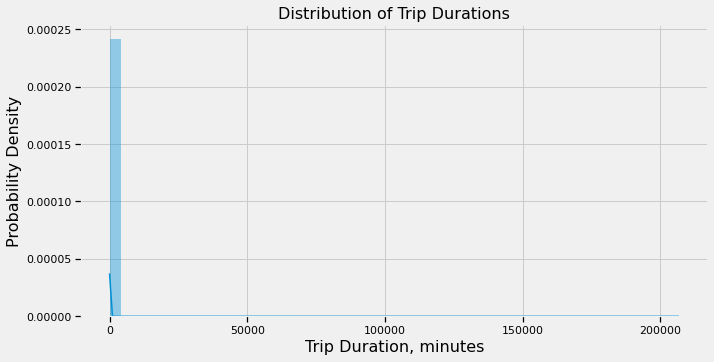

In [55]:
plt.figure(figsize=(10,5))
trip_dur=sns.distplot(a=df_trips_data['trip_duration']/60)
trip_dur.axes.set_title("Distribution of Trip Durations",
                      fontsize=16)
trip_dur.set_xlabel("Trip Duration, minutes", fontsize=16)
trip_dur.set_ylabel("Probability Density",
                  fontsize=16)
plt.show()

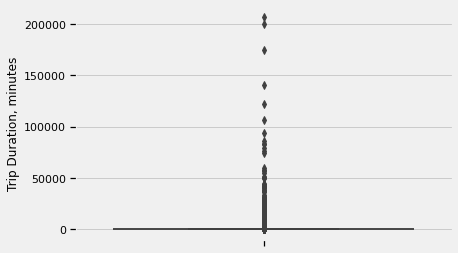

In [56]:
a=df_trips_data['trip_duration']/60
sns.boxplot(y=a).set(
    ylabel='Trip Duration, minutes')
plt.show()

It is clear from both plots that there are extreme values in the dataset and these values affect the way the dataset is represented on the graphs. It is important to note, however, that outliers may contain important information about bike sharing, particularly about the way data is collected. We recommend that the data team at the City of Toronto conduct further investigation into whether these outliers are real and how they occur in the data set if they are not.  

For the purpose of our analysis, we will remove these outliers because our objective is to analyse and model the typical and normal behavior of the bike share users that can be used to support the City in its future plans to expand the bike-share system. Particularly when using machine learning, models can be greatly improved by removing outliers from the data set.

We will use the interquartile range to remove outliers from the trip dataset. Any `'trip_duration'` values less than `Q1 - 1.5 * IQR` and greater than `Q3 + 1.5 * IQR` will be considered outliers and thus removed from the dataset. 

- Q1: The first quartile (`.quantile(0.25)`)
- Q3: The third quartile (`.quantile(0.75)`)
- IQR: The first quartil (`Q3 - Q1`)
<br>
<img src="images/probability_density.png" alt="drawing" width="450"/>
<br> 

In [57]:
original_count=df_trips_data.shape[0]

#investigate the trip duration
Q1=df_trips_data['trip_duration'].quantile(0.25)  # Q1
Q2=df_trips_data['trip_duration'].quantile(0.5)  # median
Q3=df_trips_data['trip_duration'].quantile(0.75)  # Q3
IQR=Q3-Q1

print("Q1=",Q1)
print("Q2=",Q2)
print("Q3=",Q3)
print("IQR=",IQR)


df_trips_data = df_trips_data[(df_trips_data['trip_duration'] <= (Q3 + 1.5 * IQR)) & (df_trips_data['trip_duration'] >= (Q1 - 1.5 * IQR))]

# View DataFrame
print('Number of records in Trip Dataframe: ', df_trips_data.shape[0])
print('Number of records removed from Trip Dataframe: ', original_count - df_trips_data.shape[0])
df_trips_data.sort_values(by=['trip_duration'], ascending=False).head()

Q1= 445.0
Q2= 724.0
Q3= 1141.0
IQR= 696.0
Number of records in Trip Dataframe:  8008857
Number of records removed from Trip Dataframe:  373653


,trip_id,subscription_id,trip_duration,start_station_id,start_time,start_station_name,end_station_id,end_time,end_station_name,bike_id,user_type,start_station_name_npl,end_station_name_npl
21761,8026876,581615.0,2185,7281.0,2020-06-03 22:09:00-05:00,Charles St W / Balmuto St - SMART,7281.0,2020-06-03 22:45:00-05:00,Charles St W / Balmuto St - SMART,3904.0,Casual Member,charles st w balmuto st smart,charles st w balmuto st smart
177887,3759618,NaN,2185,7242.0,2018-08-20 13:07:00-05:00,Lakeshore Blvd W / Ontario Dr,7242.0,2018-08-20 13:43:00-05:00,Lakeshore Blvd W / Ontario Dr,NaN,Casual Member,lakeshore blvd w ontario dr,lakeshore blvd w ontario dr
46853,7833212,552386.0,2185,7416.0,2020-05-13 14:55:00-05:00,Spadina Ave / Blue Jays Way,7357.0,2020-05-13 15:32:00-05:00,Lake Shore Blvd E / Leslie St,2064.0,Casual Member,spadina ave blue jays way,lake shore blvd e leslie st
104345,5085042,333359.0,2185,7171.0,2019-05-18 16:56:00-05:00,Ontario Place Blvd / Lake Shore Blvd W (East),7175.0,2019-05-18 17:32:00-05:00,HTO Park (Queens Quay W),2673.0,Casual Member,ontario place blvd lake shore blvd w east,hto park queens quay w
450249,9428282,774153.0,2185,7473.0,2020-08-29 16:18:00-05:00,Adelaide St W / Strachan Ave,7150.0,2020-08-29 16:54:00-05:00,Dufferin St / Sylvan Av (Dufferin Grove Park),5076.0,Casual Member,adelaide st w strachan ave,dufferin st sylvan av dufferin grove park


Now let's visualise the `'trip_duration'` in a histogram + density plot and box plot again. Please note that the `'trip_duration'` is displayed in minutes

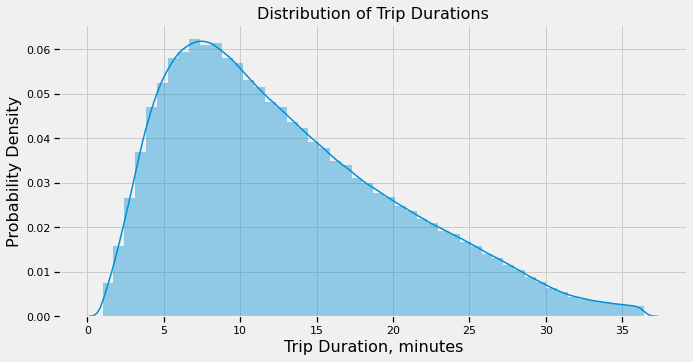

In [58]:
plt.figure(figsize=(10,5))
trip_dur=sns.distplot(a=df_trips_data['trip_duration']/60)
trip_dur.axes.set_title("Distribution of Trip Durations",
                      fontsize=16)
trip_dur.set_xlabel("Trip Duration, minutes", fontsize=16)
trip_dur.set_ylabel("Probability Density",
                  fontsize=16)
plt.show()

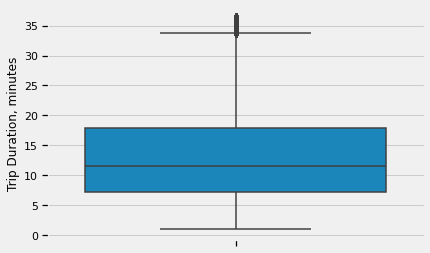

In [59]:
a=df_trips_data['trip_duration']/60
sns.boxplot(y=a).set(
    ylabel='Trip Duration, minutes')
plt.show()

In [60]:
#final check in trip dataframe to ensure there is no duplicate trip id
print("{:.0f} % of the trip Id's are unique".format(df_trips_data['trip_id'].nunique()/df_trips_data.shape[0]*100))

100 % of the trip Id's are unique


# 8. Bike Trip Data - Merging with Bike Station and Weather Data

We will merge the trip data, bike station and weather dataset into one dataframe. 
By merging the bike station data, this will allow us to merge the coordinates of the start and end location of each trip. 
By merging the weather data, we will be able to know associate each trip with the weather condition at the time the trip was taken. 

In [61]:
#Merge the stations dataframe and the df_trips_data
df_stations = stations[['station_id', 'lat', 'lon']]

#Add start stations location
df_trips_data = pd.merge(df_trips_data,df_stations, left_on = 'start_station_id', right_on = 'station_id', how = 'left')
df_trips_data.rename(columns = {'lat':'start_station_lat', 'lon': 'start_station_lon'},inplace = True)
df_trips_data.drop('station_id', axis = 1, inplace = True)

#Add end stations location
df_trips_data = pd.merge(df_trips_data,df_stations, left_on = 'end_station_id', right_on = 'station_id', how = 'left')
df_trips_data.rename(columns = {'lat':'end_station_lat', 'lon': 'end_station_lon'},inplace = True)
df_trips_data.drop('station_id', axis = 1, inplace = True)

df_trips_data.head()

,trip_id,subscription_id,trip_duration,start_station_id,start_time,start_station_name,end_station_id,end_time,end_station_name,bike_id,user_type,start_station_name_npl,end_station_name_npl,start_station_lat,start_station_lon,end_station_lat,end_station_lon
0,712441,NaN,274,7006.0,2017-01-01 00:03:00-05:00,Bay St / College St (East Side),7021.0,2017-01-01 00:08:00-05:00,Bay St / Albert St,NaN,Member,bay st college st east side,bay st albert st,43.660439,-79.385525,43.653264,-79.382458
1,5206483,259072.0,1400,7155.0,2019-06-01 00:00:00-05:00,Bathurst St / Lennox St,7105.0,2019-06-01 00:23:00-05:00,Queen St E / Sackville St,778.0,Annual Member,bathurst st lennox st,queen st e sackville st,43.663808,-79.410491,43.656111,-79.361389
2,1082246,NaN,551,7004.0,2017-06-01 00:00:00-05:00,University Ave / Elm St,7034.0,2017-06-01 00:09:00-05:00,Church St / Bloor St E,NaN,Member,university ave elm st,church st bloor st e,43.656518,-79.389099,43.671389,-79.382919
3,1971685,NaN,849,7275.0,2017-10-01 00:00:00-05:00,Queen St W / James St,7131.0,2017-10-01 00:14:00-05:00,Taddle Creek Park,NaN,Member,queen st w james st,taddle creek park,43.652276,-79.380701,43.669860,-79.398443
4,5533843,376806.0,1834,7352.0,2019-07-01 00:00:00-05:00,Cosburn Ave / Donlands Ave,7352.0,2019-07-01 00:30:00-05:00,Cosburn Ave / Donlands Ave,989.0,Casual Member,cosburn ave donlands ave,cosburn ave donlands ave,43.690537,-79.341307,43.690537,-79.341307


It has been identified that some of the stations named in in the trip data are not included in the bike station dataset. For this reason, we could not assign the location coordinates to the trip record. The stations not included in the station dataset are:
- Toronto Bike Shop
- Wolfpack - 7219
- 135 Queen's Wharf - SMART
- 55 Magnificent Rd. Garage
- PBSC-OPS
- Make Invisible - 7218 

We highly recommend the City of Toronto to investigate verify why these bike stations are not included in the bike station dataset. 

There are 242 records missing the start coordinate information. There are 426 records missing the end coordinate information. We have removed these records from our analysis as these bike stations were not included in the provided bike station list. We recommend that the City of Toronto investigate this further and advise us as to whether they would like these trip records included in our analysis. For now, they will be removed as we are uncertain about h

In [62]:
#end station ids that have null coordinate information
print(df_trips_data[df_trips_data['end_station_lon'].isnull()]['end_station_id'].unique())
#end station names that have null coordinate information
print(df_trips_data[df_trips_data['end_station_lon'].isnull()]['end_station_name'].unique())

[7394. 7219. 7532. 7218. 7511.]
['Toronto Bike Shop' 'Wolfpack - 7219' '135 Queen’s Wharf - SMART'
 'Make Invisible - 7218' 'PBSC-OPS']


In [63]:
#start station ids that have null coordinate information
print(df_trips_data[df_trips_data['start_station_lon'].isnull()]['start_station_id'].unique())
#start station names that have null coordinate information
print(df_trips_data[df_trips_data['start_station_lon'].isnull()]['start_station_name'].unique())

[7394. 7219. 7532. 7393. 7218. 7511.]
['Toronto Bike Shop' 'Wolfpack - 7219' '135 Queen’s Wharf - SMART'
 '55 Magnificent Rd. Garage' 'Make Invisible - 7218' 'PBSC-OPS']


In [64]:
#Percentage of Data Containing Null Record for 'start_station_lat','start_station_lon','end_station_lat','end_station_lon'
df_trips_data_missing = pd.DataFrame(df_trips_data.isnull().sum())
df_trips_data_missing = df_trips_data_missing.rename(columns={0:"count"})
df_trips_data_missing['percent_nulldata']=round(df_trips_data_missing['count']/df_trips_data.shape[0] * 100,1)

df_trips_data_missing.loc[['start_station_lat','start_station_lon','end_station_lat','end_station_lon'],:]

,count,percent_nulldata
start_station_lat,242,0.0
start_station_lon,242,0.0
end_station_lat,426,0.0
end_station_lon,426,0.0


In [65]:
#Remove all trip records with start or end bike station not included in the bike station dataset
df_trips_data=df_trips_data[df_trips_data['start_station_lat'].notnull() & df_trips_data['end_station_lat'].notnull()]

We use the .merge() function to combine weather_data and trips_data using datetime information and set the output to a new variable called df_data_merged. In trips_data there are two time stamps corresponding to the start and end of the ride. We have used the'start_time' of the rides to merge. We believe this is the most appropriate method because we anticipate that bike riders will make a decision to use the bike or not based on the weather condition at the start of the trip, not the end. 

The datetimes in the trips_data datetimes contain information down to the minute, while weather_data is reported every hour. Thus, we merged based on a common year, month, day, hour.

In [66]:
df_trips_data['merge_time']=df_trips_data['start_time'].dt.round('H')
df_data_merged = pd.merge(df_trips_data, df_weather_data, left_on='merge_time', right_index=True, how='left')
df_data_merged.set_index('trip_id', inplace = True)
df_data_merged.sort_index(inplace=True)
print('Number of records in Merged Dataframe: ', df_data_merged.shape[0])
df_data_merged.head()

Number of records in Merged Dataframe:  8008200


,subscription_id,trip_duration,start_station_id,start_time,start_station_name,end_station_id,end_time,end_station_name,bike_id,user_type,...,temp_c,dew_point_temp_c,rel_hum_,wind_dir_10s_deg,wind_spd_kmh,visibility_km,stn_press_kpa,hmdx,wind_chill,weather
trip_id,,,,,,,,,,,,,,,,,,,,,
712441,NaN,274,7006.0,2017-01-01 00:03:00-05:00,Bay St / College St (East Side),7021.0,2017-01-01 00:08:00-05:00,Bay St / Albert St,NaN,Member,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day
712442,NaN,538,7046.0,2017-01-01 00:03:00-05:00,Niagara St / Richmond St W,7147.0,2017-01-01 00:12:00-05:00,King St W / Fraser Ave,NaN,Member,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day
712443,NaN,992,7048.0,2017-01-01 00:05:00-05:00,Front St / Yonge St (Hockey Hall of Fame),7089.0,2017-01-01 00:22:00-05:00,Church St / Wood St,NaN,Member,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day
712444,NaN,1005,7177.0,2017-01-01 00:09:00-05:00,East Liberty St / Pirandello St,7202.0,2017-01-01 00:26:00-05:00,Queen St W / York St (City Hall),NaN,Member,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day
712445,NaN,645,7203.0,2017-01-01 00:14:00-05:00,Bathurst St / Queens Quay W,7010.0,2017-01-01 00:25:00-05:00,King St W / Spadina Ave,NaN,Member,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day


Based on the information below, we know that:
- 0.6% of the trips do not have information about the temperature
- 0.7% of the trips do not have information about dew point temperature and relative humidity
- 0.2% of the trips do not have information about the wind speed and direction


We will leave these trip records in the dataset for analyses that does not require the weather data. 

In [67]:
#Percentage of Data Containing Null Record
merged_data_missing = pd.DataFrame(df_data_merged.isnull().sum())
merged_data_missing = merged_data_missing.rename(columns={0:"count"})
merged_data_missing['percent_nulldata']=round(merged_data_missing['count']/df_data_merged.shape[0] * 100,1)

merged_data_missing.loc[df_data_merged.columns[17:],:]

,count,percent_nulldata
year,0,0.0
month,0,0.0
day,0,0.0
time,0,0.0
temp_c,48476,0.6
dew_point_temp_c,59008,0.7
rel_hum_,57615,0.7
wind_dir_10s_deg,14178,0.2
wind_spd_kmh,14178,0.2
visibility_km,0,0.0


## User Type Definition
The naming convention is not uniform <br>
<b> Annual Member: </b><br>
<ul>
    <li> Member </li>
    <li> Annual Member </li>
</ul>

<b>Casual Member: </b><br>
<ul>
    <li> Member </li>
    <li> Casual Member </li>
</ul>
Set all to either <code> 'casual member' </code> or <code> 'annual member' </code> 


In [69]:
df_trips_data['user_type'].unique()

array(['Member', 'Annual Member', 'Casual Member', 'Casual'], dtype=object)

In [70]:
df_trips_data['user_type'] = df_trips_data['user_type'].str.lower()
df_trips_data['user_type'] = df_trips_data['user_type'].replace({'member':'annual member', 'casual':'casual member'})
df_trips_data['user_type'].unique()

array(['annual member', 'casual member'], dtype=object)

The merged dataframe will be saved as a csv file to use for the Exploratory Data Analysis. 

In [72]:
#Export the merged dataframe in csv format
df_data_merged.to_csv('df_merged_data.csv')

This concludes the data wrangling and cleaning process for the bike trip and weather data. The final output of this file is a dataframe that includes both bike share and weather data features from 2017 to 2020 with each row corresponding to a trip.